In [13]:
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox
import statsmodels.api as sm
import scipy.stats as stats

from src.utils.load_dataframe import load_time_series_60min


In [14]:
def inv_boxcox(y, lam):
    return np.exp(np.log(lam * y + 1) / lam) if lam != 0 else np.exp(y)

In [15]:
warnings.filterwarnings("ignore")

In [16]:
df = load_time_series_60min()

In [17]:
# Convert 'utc_timestamp' to datetime and set as index
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'], utc=True)
df.set_index('utc_timestamp', inplace=True)

In [18]:
# Select relevant column and interpolate missing values
target_variable = 'DE_load_actual_entsoe_transparency'
df[target_variable] = df[target_variable].interpolate(method='time')

In [19]:
# Use last two years of data for faster computation
series = df[target_variable].dropna().asfreq('h').last('2Y')

In [20]:
# Split into training and test sets (80% train, 20% test)
train_size = int(len(series) * 0.8)
train_data, test_data = series.iloc[:train_size], series.iloc[train_size:]

In [21]:
# Apply Box-Cox transformation
train_data_transformed_values, lam = boxcox(train_data)

# Convert to pandas Series
train_data_transformed = pd.Series(train_data_transformed_values, index=train_data.index)

In [22]:
# Determine differencing order
d = ndiffs(train_data_transformed, test='adf')
D = nsdiffs(train_data_transformed, m=168, test='ocsb')
print(f'Optimal d: {d}, Optimal D: {D}')

Optimal d: 0, Optimal D: 0


<Figure size 1000x500 with 0 Axes>

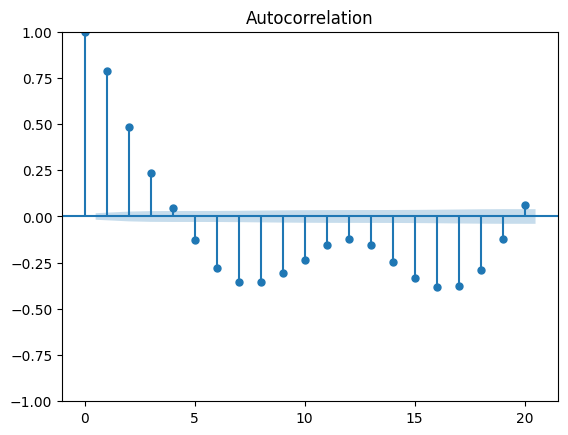

<Figure size 1000x500 with 0 Axes>

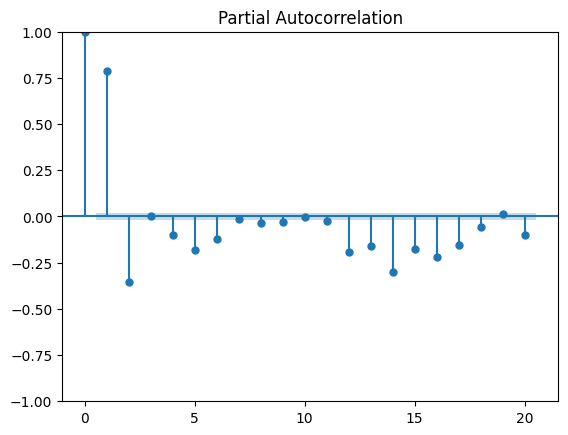

: 

In [23]:
# Plot ACF and PACF for transformed series
plt.figure(figsize=(10, 5))
plot_acf(train_data_transformed.diff().dropna(), lags=20)
plt.show()

plt.figure(figsize=(10, 5))
plot_pacf(train_data_transformed.diff().dropna(), lags=20)
plt.show()

In [24]:
# Use auto_arima to find the best SARIMA parameters
# **Simplify Parameter Grid**
stepwise_model = pm.auto_arima(
train_data_transformed,
start_p=0, max_p=1,    # Reduced from 2 to 1
start_q=0, max_q=1,    # Reduced from 2 to 1
start_P=0, max_P=1,    # Reduced from 1 to 0 (no seasonal AR terms)
start_Q=0, max_Q=1,    # Reduced from 1 to 0 (no seasonal MA terms)
d=d,
D=D,
m=168,  # Weekly seasonality
seasonal=True,
trace=False,
error_action='ignore',
suppress_warnings=True,
stepwise=True,
max_order=4,   # Further limit model complexity
maxiter=20,    # Reduce iterations for faster computation
n_jobs=1
)

In [13]:
print(stepwise_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 5260
Model:             SARIMAX(2, 1, 2)x(1, 1, [], 24)   Log Likelihood              -43454.408
Date:                             Thu, 12 Sep 2024   AIC                          86920.817
Time:                                     20:23:08   BIC                          86960.196
Sample:                                 01-01-2020   HQIC                         86934.587
                                      - 08-07-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6436      0.109      5.897      0.000       0.430       0.858
ar.L2         -0.2715      

In [14]:
# Forecast
n_periods = len(test_data)
fc_transformed, confint = stepwise_model.predict(n_periods=n_periods, return_conf_int=True)

In [ ]:
# Inverse Box-Cox transformation
fc = inv_boxcox(fc_transformed, lam)
lower_series = inv_boxcox(confint[:, 0], lam)
upper_series = inv_boxcox(confint[:, 1], lam)
fc_series = pd.Series(fc, index=test_data.index)

In [ ]:
# Calculate error metrics
mse = mean_squared_error(test_data, fc)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, fc)
mape = np.mean(np.abs((test_data - fc) / test_data)) * 100
smape = 100/len(test_data) * np.sum(2 * np.abs(fc - test_data) / (np.abs(test_data) + np.abs(fc)))
r2 = r2_score(test_data, fc)
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'Symmetric MAPE (sMAPE): {smape:.2f}%')
print(f'R-squared: {r2:.4f}')

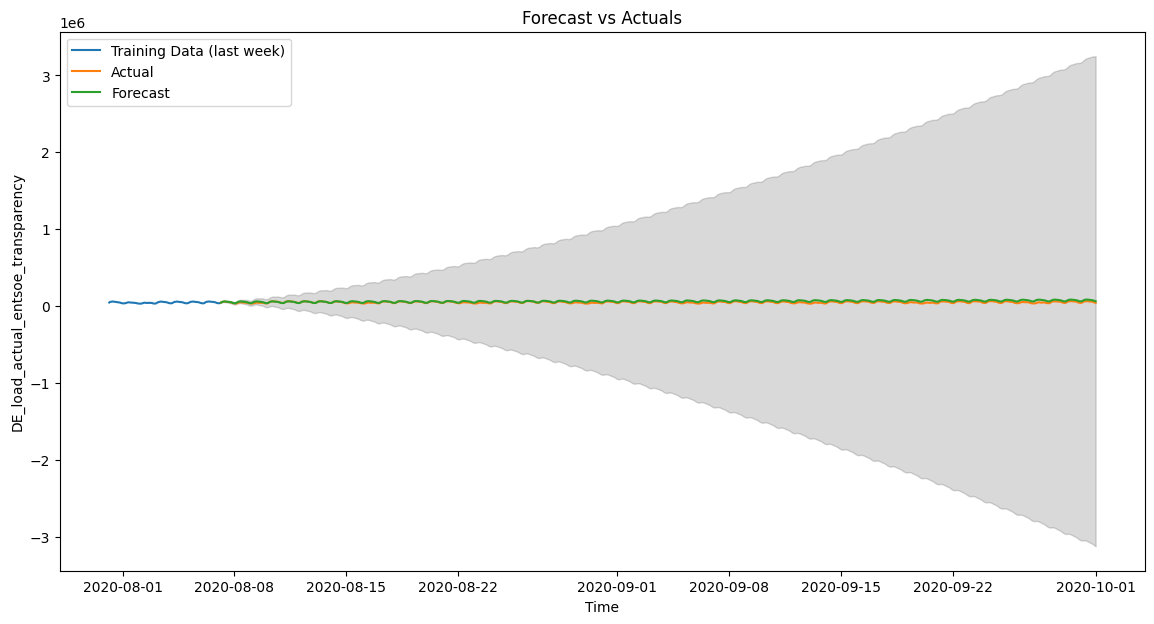

In [17]:
# Plot the forecast vs actuals
plt.figure(figsize=(14, 7))
plt.plot(train_data[-168:], label='Training Data (last week)')
plt.plot(test_data, label='Actual')
plt.plot(fc_series, label='Forecast')
plt.fill_between(test_data.index, lower_series, upper_series, color='k', alpha=0.15)
plt.title('Forecast vs Actuals')
plt.xlabel('Time')
plt.ylabel(target_variable)
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Residual analysis
residuals = test_data - fc_series

In [ ]:
# Plot residuals over time
plt.figure(figsize=(14, 7))
plt.plot(residuals)
plt.title('Residuals over Time')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()


In [ ]:
# Histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=50, density=True, alpha=0.6, color='g')

In [ ]:
# Plot the normal distribution fit
mu, std = stats.norm.fit(residuals)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

In [ ]:
# QQ-plot of residuals
sm.qqplot(residuals, line='s')
plt.title('QQ Plot of Residuals')
plt.show()

In [ ]:
# ACF and PACF plots of residuals
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(residuals, lags=50, ax=axes[0])
plot_pacf(residuals, lags=50, ax=axes[1])
axes[0].set_title('ACF of Residuals')
axes[1].set_title('PACF of Residuals')
plt.show()

In [ ]:
# Ljung-Box test
lb_test = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)
print('Ljung-Box test:')
print(lb_test)